In [ ]:
# """" To install Packages run this Cell if the packages are already present in the environment Please ignore this cell"""
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

## Data Dictionary
 
      Data has both the categorical features and numerical features and a identifier column and Dependent Variable column.
      
### Categorical Columns
      The Categorical columns are represented as C1 to C8  [C1,....,C8]

### Numerical Columns
      The Numerical Columns are represented as N1 to N35  [N1,....,N35]

# Loading Packages

In [85]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None #To ignore SettingWithoutCopy Warning


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, recall_score

import matplotlib.pyplot as plt
import seaborn as sns



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Data Loading

Loading data from csv files to pandas dataframe and converting dependent and independent features into a single dataframe.

In [53]:
Train_path = "./Training"
x_data = pd.read_csv(Train_path+"/X_train.csv")
y_data = pd.read_csv(Train_path+"/Y_train.csv")
data = pd.merge(x_data,y_data,on="Unique_ID",how="inner")

In [54]:
# Data Column named Wrongly in the Data
data = data.rename(columns={"N10.1":"N13"})

In [55]:
data.head()

Unique_ID  C1  C2  C3  C4  C5     C6  C7    C8     N1  ...  N27  N28  \
0   Candidate_5926   1   0  11  31   0  False   0  True  23.75  ...  NaN  NaN   
1  Candidate_48134   1   4   2  66   2  False   1  True  11.05  ...  NaN  NaN   
2  Candidate_51717   1   0  19   2   0  False   0  True  29.00  ...  NaN  NaN   
3  Candidate_26401   1   1  16  47   1  False   4  True  17.99  ...  NaN  NaN   
4  Candidate_34872   1   1  13   1   1   True   6  True  27.50  ...  NaN  NaN   

   N29  N30  N31  N32    N33     N34   N35  Dependent_Variable  
0  NaN  NaN  NaN  NaN   58.0  113.39  12.0                   1  
1  NaN  NaN  NaN  NaN  160.0  262.10  17.0                   0  
2  NaN  NaN  NaN  NaN   24.0   50.29  18.0                   1  
3  NaN  NaN  NaN  NaN   70.0  126.52  27.0                   0  
4  NaN  NaN  NaN  NaN  100.0  205.47  21.0                   0  

[5 rows x 45 columns]

### Extracting catogorical columns and numerical columns from the Data

In [56]:
cat_cols = []
num_cols = []
for col in data.columns:
    if 'C' in col:
        cat_cols.append(col)
    elif 'N' in col:
        num_cols.append(col)

#  Data Preprocessing 

Before Bulding a model we must check the data and do some prerocessing on the data to Make Better Predictions 

# Missing Values

Check the data for missing values and deal with them appropriately 

In [57]:
data.isnull().sum()

Unique_ID                 0
C1                        0
C2                        0
C3                        0
C4                        0
C5                        0
C6                        0
C7                        0
C8                        0
N1                        0
N2                     4612
N3                      365
N4                     4606
N5                     4606
N6                      365
N7                      427
N8                        0
N9                        0
N10                     427
N13                     427
N11                     716
N12                    4614
N14                     608
N15                     427
N16                    4606
N17                    4606
N18                    4606
N19                    4571
N20                    4571
N21                    4571
N22                    4571
N23                    2486
N24                       0
N25                   26779
N26                   26779
N27                 

This shows that there are few columns with null values in the dataset. A point to not is that all the columns that contain the null vales are numerical columns. 

### Getting null value columns

In [58]:
null_cols = [col for col in data.columns if data[col].isnull().sum()>0]
print(null_cols)

['N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N10', 'N13', 'N11', 'N12', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N35']


## Dealing with null values

The null values are filled with median of the column. Experiments with filling null values with both mean and median were conducted , But there was not significant difference in the Accuracy Score. 

In [59]:
data_cleaned = data.copy() 

In [60]:
for col in null_cols:
        data_cleaned[col] = data[col].fillna(value = data[col].median())

In [12]:
# data_cleaned.isnull().sum()

# Outliers

There are some outliers in the Data. Dealing with then will improve the performence of our model. An Plot showing the outliears of a col is given in the below figure 

In [61]:
sns.boxplot(data_cleaned['N8'],orient='v')

<AxesSubplot:xlabel='N8'>

We can deal with the outliers similar to null values. Another method is that we can  substituted the ouliear values with Wisker values of the Quartiles or first and third quartile etc.

In [62]:
for col in num_cols:
    if col not in null_cols:
        IQR = data_cleaned[col].quantile(0.75) - data_cleaned[col].quantile(0.25)
        Q1 = data_cleaned[col].quantile(0.25)
        Q3 = data_cleaned[col].quantile(0.75)
        whisker_1 = Q1 - (1.5*IQR)
        whisker_2 = Q3 + (1.5*IQR)
        data_cleaned[col].loc[data_cleaned[col]<whisker_1] = Q1
        data_cleaned[col].loc[data_cleaned[col]>whisker_2] = Q3

<AxesSubplot:xlabel='N8'>

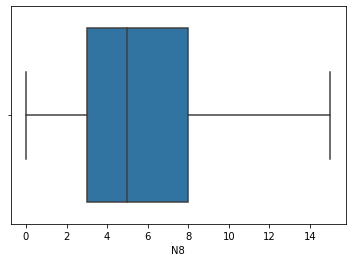

In [63]:
# Oulers are removed
sns.boxplot(data_cleaned['N8'],orient='v')

## Data distrubution of numerical Features 

<AxesSubplot:xlabel='N8', ylabel='Density'>

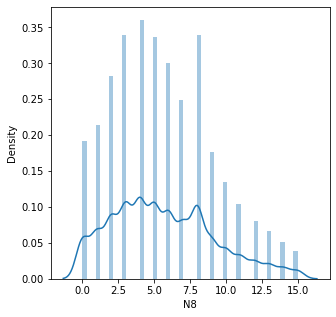

In [69]:
# Data distrubution for N8 Column
plt.figure(figsize=(5,5))
sns.distplot(data_cleaned['N8'])

## Corelation Between Features

### Catogorical variables 

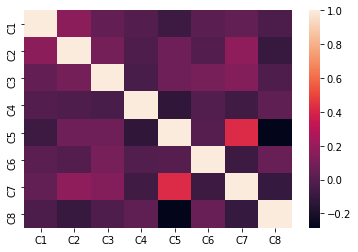

In [64]:
cat_correlations = data_cleaned[cat_cols].corr()
sns.heatmap(cat_correlations)
plt.show()

### Numerical Variables

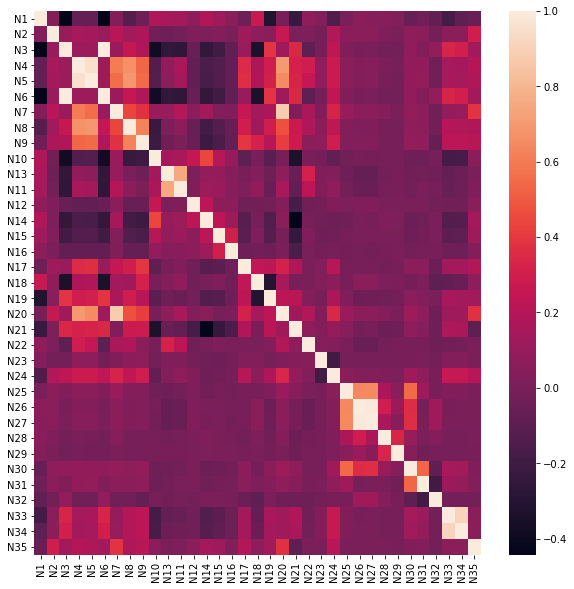

In [70]:
num_correlations = data_cleaned[num_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(num_correlations)
plt.show()

There are Some Pairs of features Which are highly Correlated like (N7,N20) (N3,N6).

## Categorical Feature Encoding

In [72]:
X = data_cleaned[cat_cols+num_cols]
Y = data_cleaned['Dependent_Variable']
X.head()

C1  C2  C3  C4  C5     C6  C7    C8     N1     N2  ...   N26   N27  N28  \
0   1   0  11  31   0  False   0  True  23.75   53.0  ...  15.0  14.0  0.0   
1   1   4   2  66   2  False   1  True  11.05   22.0  ...  15.0  14.0  0.0   
2   1   0  19   2   0  False   0  True  29.00   53.0  ...  15.0  14.0  0.0   
3   1   1  16  47   1  False   4  True  17.99    1.0  ...  15.0  14.0  0.0   
4   1   1  13   1   1   True   6  True  27.50  206.0  ...  15.0  14.0  0.0   

   N29     N30      N31  N32    N33     N34   N35  
0  0.0  5000.0  1108.44  0.0   58.0  113.39  12.0  
1  0.0  5000.0  1108.44  0.0  160.0  262.10  17.0  
2  0.0  5000.0  1108.44  0.0   24.0   50.29  18.0  
3  0.0  5000.0  1108.44  0.0   70.0  126.52  27.0  
4  0.0  5000.0  1108.44  0.0  100.0  205.47  21.0  

[5 rows x 43 columns]

Here the Columns C6 and C8 Have values which are not ordinal in nature. So we encode the columns with Label encoder 

In [74]:
X['C6'] = LabelEncoder().fit_transform(X['C6'])
X['C8'] = LabelEncoder().fit_transform(X['C8'])

In [75]:
X.head()

C1  C2  C3  C4  C5  C6  C7  C8     N1     N2  ...   N26   N27  N28  N29  \
0   1   0  11  31   0   0   0   1  23.75   53.0  ...  15.0  14.0  0.0  0.0   
1   1   4   2  66   2   0   1   1  11.05   22.0  ...  15.0  14.0  0.0  0.0   
2   1   0  19   2   0   0   0   1  29.00   53.0  ...  15.0  14.0  0.0  0.0   
3   1   1  16  47   1   0   4   1  17.99    1.0  ...  15.0  14.0  0.0  0.0   
4   1   1  13   1   1   1   6   1  27.50  206.0  ...  15.0  14.0  0.0  0.0   

      N30      N31  N32    N33     N34   N35  
0  5000.0  1108.44  0.0   58.0  113.39  12.0  
1  5000.0  1108.44  0.0  160.0  262.10  17.0  
2  5000.0  1108.44  0.0   24.0   50.29  18.0  
3  5000.0  1108.44  0.0   70.0  126.52  27.0  
4  5000.0  1108.44  0.0  100.0  205.47  21.0  

[5 rows x 43 columns]

## Scaling Numerical Features 

Here the numerical Features are of different ranges. It will lead to inaccurate prediction with distance based Model. So The Numerical  feature columns are Scaled Using MinMax Scalar. 

In [76]:
X[num_cols] = MinMaxScaler().fit_transform(X[num_cols])

In [78]:
# X.head()

In [79]:
# Spliting Data to train and test Set

xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.3, random_state=11, stratify = Y)

## Modeling

Two Model Are Considered and exprimented on for their powerfull classification Abilities

* Support Vector Machines(SVM)
* RandomForest

Various Experiments Are Done And Svm With linear Kernel was selected For SVM Model

### SVM 

In [82]:
model_svm = SVC(kernel='linear',probability=True)
model_svm.fit(xtrain, ytrain)
svm_predictions = model_svm.predict(xtest)
svm_prob_pred = model_svm.predict_proba(xtest)[:,1]


# Recall and accuracy score
svm_accuracy = accuracy_score(ytest,svm_predictions)
svm_recall = recall_score(ytest,svm_predictions)

### Confusion Matrix For SVM Model

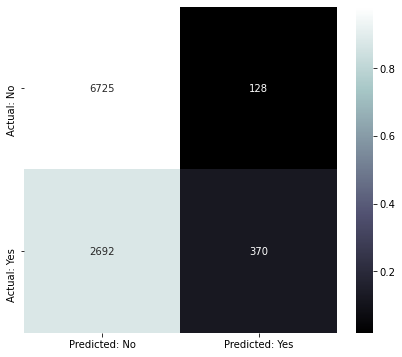

In [83]:
label_preds = svm_predictions

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

# Random Forest Model

Multiple Experiments with Variying Depth of the Forest were Done. One Experiment was Finalized

In [86]:
model_random = RandomForestClassifier(max_depth=20, random_state=0)

model_random.fit(xtrain, ytrain)
Random_predictions = model_random.predict(xtest)
Random_prob_pred = model_random.predict_proba(xtest)[:,1]

Random_accuracy = accuracy_score(ytest,svm_predictions)
Random_recall = recall_score(ytest,svm_predictions)

### Confusion Matrix For Random Forest

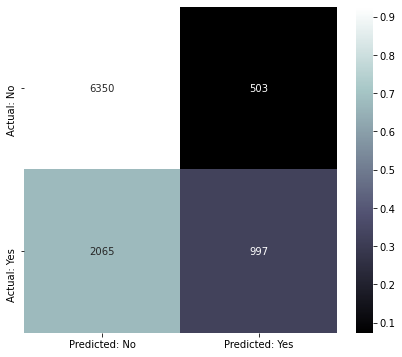

In [88]:
label_preds = Random_predictions

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

## ROC Curves Of Both SVM And RandomForest Models

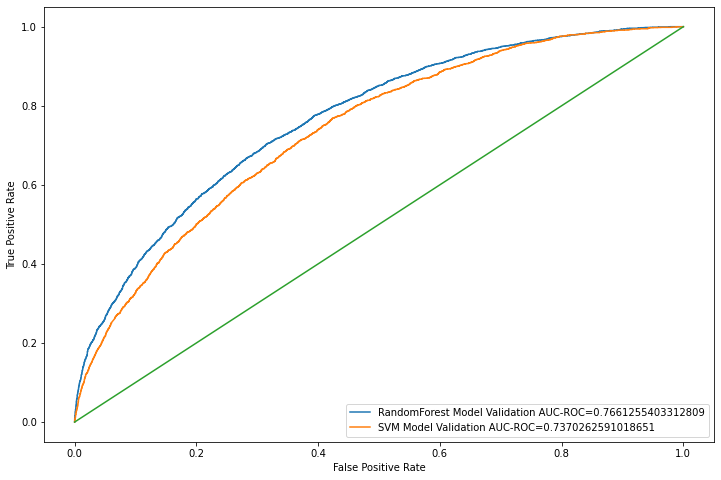

In [89]:
svm_fpr, svm_tpr, _ = roc_curve(ytest,svm_prob_pred) 
fpr,tpr,_ = roc_curve(ytest,Random_prob_pred)
svm_auc = roc_auc_score(ytest, svm_prob_pred) 
auc = roc_auc_score(ytest, Random_prob_pred)
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="RandomForest Model Validation AUC-ROC="+str(auc)) 
plt.plot(svm_fpr,svm_tpr,label="SVM Model Validation AUC-ROC="+str(svm_auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [126]:
import pickle 

pickle.dump(model_random, open('RandomForest.pkl','wb'))
pickle.dump(model_svm, open('SVM.pkl','wb'))

# Predicting Test Data

### Random Forest Model is Used To Predict Final Data

In [128]:
Test_path = "./Test"
df = pd.read_csv(Test_path+"/X_test.csv")
df = df.rename(columns={"N10.1":"N13"})

In [129]:
df_clean = df.copy()
for col in null_cols:
        df_clean[col] = df[col].fillna(value = df[col].median())

In [130]:
for col in num_cols:
    if col not in null_cols:
        IQR = df_clean[col].quantile(0.75) - df_clean[col].quantile(0.25)
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        whisker_1 = Q1 - (1.5*IQR)
        whisker_2 = Q3 + (1.5*IQR)
        df_clean[col].loc[df_clean[col]<whisker_1] = Q1
        df_clean[col].loc[df_clean[col]>whisker_2] = Q3

In [131]:
df_clean['C6'] = LabelEncoder().fit_transform(df_clean['C6'])
df_clean['C8'] = LabelEncoder().fit_transform(df_clean['C8'])
df_clean[num_cols] = MinMaxScaler().fit_transform(df_clean[num_cols])

In [132]:
Y = model_random.predict_proba(df_clean[cat_cols+num_cols])[:,1]
df_clean['Class_1_Probability'] = Y

In [133]:
df_clean.head()

Unique_ID  C1  C2  C3  C4  C5  C6  C7  C8        N1  ...       N27  \
0   Candidate_1602   1   0   0  23   0   1   0   1  0.480000  ...  0.131579   
1  Candidate_29650   1   0   2   4   2   1   2   1  0.446667  ...  0.131579   
2  Candidate_31061   1   2   3  38   1   0   4   1  0.799733  ...  0.052632   
3   Candidate_5768   1   1  28  20   2   0   2   1  0.472000  ...  0.131579   
4  Candidate_27059   1   1  15   1   3   0   5   0  0.746667  ...  0.131579   

   N28  N29       N30       N31       N32       N33       N34       N35  \
0  0.0  0.0  0.093985  0.040157  0.425974  0.100671  0.149009  0.370370   
1  0.0  0.0  0.093985  0.040157  0.425974  0.939597  0.878639  0.240741   
2  0.0  0.0  0.093985  0.199535  0.212987  0.201342  0.279916  0.351852   
3  0.0  0.0  0.093985  0.040157  0.425974  0.436242  0.445181  0.185185   
4  0.0  0.0  0.093985  0.040157  0.425974  0.100671  0.170492  0.203704   

   Class_1_Probability  
0             0.491997  
1             0.417432  
2             0.501220  
3             0.261145  
4             0.502374  

[5 rows x 45 columns]

In [134]:
final = df_clean[['Unique_ID','Class_1_Probability']]

In [135]:
final.head()

Unique_ID  Class_1_Probability
0   Candidate_1602             0.491997
1  Candidate_29650             0.417432
2  Candidate_31061             0.501220
3   Candidate_5768             0.261145
4  Candidate_27059             0.502374

In [137]:
final.to_csv(Test_path+"/final_predictions.csv")